# Elbow Point 계산 라이브러리 활용

> iris 데이터셋

## #01. 준비작업

### [1] 패키지 가져오기

In [2]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# 내장된 컬러맵, 컬러맵 처리 유틸리티
from matplotlib import cm

# Elbow Point 계산 라이브러리
from kneed import KneeLocator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [2] 데이터 가져오기

In [3]:
origin: DataFrame = my_read_excel(path="https://data.hossam.kr/mldata/iris.xlsx", 
                                  categories=['Species'], info=False)

## #02. 데이터 전처리

1. 종속변수 제거
2. MinMax Scaling

In [4]:
df = origin.drop('Species', axis=1)
df = my_minmax_scaler(df)
df

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667
...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667
146,0.555556,0.208333,0.677966,0.750000
147,0.611111,0.416667,0.711864,0.791667
148,0.527778,0.583333,0.745763,0.916667


## #03. Elbow Point 구하기

### [1] 클러스터 수를 늘려가면서 inertia 값 구하기

In [5]:
klist = list(range(2,11))

inertia = []

for k in klist:
    estimator = KMeans(n_clusters=k, random_state=0)
    estimator.fit(X=df)
    inertia.append(estimator.inertia_)
    
inertia

[12.127790750538177,
 7.122750172943852,
 5.533861640150963,
 5.0146004910698,
 4.2693532003880925,
 3.6750880379692483,
 3.517475590581651,
 2.894724979190105,
 2.757339896443214]

### [2] Elbow Point 구하기

| 파라미터 | 값 | 의미 |
|---|---|---|
| curve | convex | 볼록함 |
| curve | concave | 오목함 |
| direction | increasing | x가 커짐에 따라 y가 점점 커짐 |
| direction | decreasing | x가 커짐에 따라 y가 점점 작아짐 |

![img](res/knee.png)

In [6]:
k1 = KneeLocator(klist, inertia, curve='convex', direction='decreasing')
best_k = k1.elbow
best_y = k1.elbow_y
print('found elbow: ', best_k)
print('found y: ', best_y)


found elbow:  4
found y:  5.533861640150963


### [3] Elbow Point 시각화

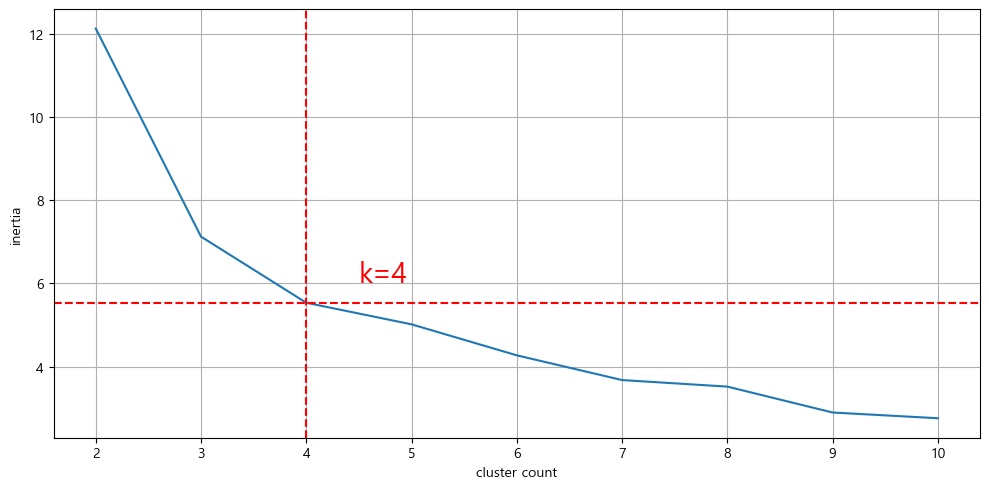

In [7]:
def hvline(ax):
    ax.set_ylabel('inertia')
    ax.set_xlabel('cluster count')
    ax.axhline(best_y, color = 'red', linestyle='--')
    ax.axvline(best_k, color = 'red', linestyle='--')
    ax.text(best_k+0.5, best_y+0.5, f'k={best_k}', fontsize=20, color='red')
  
my_lineplot(df=None, xname=klist, yname=inertia, callback=hvline)

## #04. 도출된 Elbow Point를 사용한 군집

### [1] 군집분석

In [8]:
estimator = KMeans(n_clusters=best_k, random_state=333)
estimator.fit(df)

KMeans(n_clusters=4, random_state=333)

### [2] 군집결과 확인

#### 각 군집의 중심점

In [9]:
estimator.cluster_centers_

array([[0.73850575, 0.47270115, 0.82291058, 0.86350575],
       [0.19611111, 0.595     , 0.07830508, 0.06083333],
       [0.35632184, 0.23706897, 0.50905903, 0.47126437],
       [0.54166667, 0.375     , 0.65657789, 0.64186508]])

#### 결과 데이터

In [11]:
result_df = df.copy()
result_df['cluster'] = estimator.labels_
result_df

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,cluster
0,0.222222,0.625000,0.067797,0.041667,1
1,0.166667,0.416667,0.067797,0.041667,1
2,0.111111,0.500000,0.050847,0.041667,1
3,0.083333,0.458333,0.084746,0.041667,1
4,0.194444,0.666667,0.067797,0.041667,1
...,...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667,0
146,0.555556,0.208333,0.677966,0.750000,3
147,0.611111,0.416667,0.711864,0.791667,3
148,0.527778,0.583333,0.745763,0.916667,0


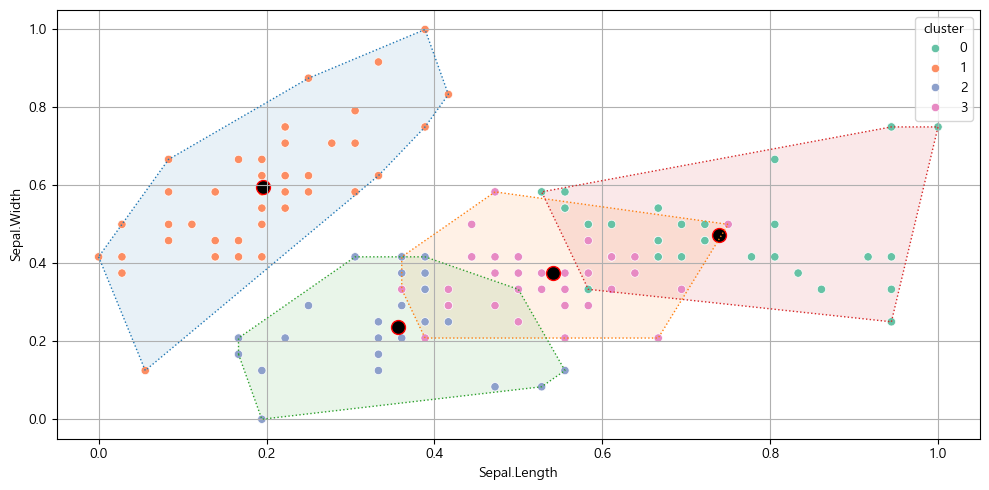

In [14]:
my_convex_hull(data = result_df, xname='Sepal.Length', yname='Sepal.Width',
               hue='cluster', palette='Set2',
               callback=lambda ax: ax.scatter(
                   estimator.cluster_centers_[:,0],
                   estimator.cluster_centers_[:,1],
                   marker='o',
                   c='black',
                   alpha=1,
                   s=100,
                   edgecolor='red'
               ))                